In [18]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from pylab import rcParams
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from tqdm import tqdm_notebook
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
import pymannkendall as mk
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

In [2]:
data=pd.read_csv('SoDa_MERRA2_lat4.847_lon6.975_1980-01-01_2020-12-31_501774438.csv',parse_dates=['# Date'],index_col=['# Date'])

In [3]:
data

,Temperature,Relative Humidity,Pressure,Wind speed,Wind direction,Rainfall,Short-wave irradiation
# Date,,,,,,,
1980-01-31,299.41,79.15,1007.80,1.25,254.23,54.253944,154270.1
1980-02-28,299.77,80.01,1006.45,1.59,242.10,111.454992,139898.3
1980-03-31,299.50,84.17,1006.99,1.74,225.68,159.547680,132470.7
1980-04-30,299.21,85.96,1007.23,1.78,218.81,115.285752,124236.6
1980-05-31,298.97,87.68,1008.68,1.55,233.21,330.417864,120979.0
...,...,...,...,...,...,...,...
2020-08-31,298.07,85.80,1009.83,2.23,240.69,95.613480,166646.9
2020-09-30,298.17,89.20,1009.45,1.91,226.10,419.964840,118967.3
2020-10-31,298.75,87.71,1008.84,1.43,223.57,238.740084,119097.1


In [14]:
ts=data['Temperature'].resample('M').mean()
ts

# Date
1980-01-31    299.41
1980-02-29    299.77
1980-03-31    299.50
1980-04-30    299.21
1980-05-31    298.97
               ...  
2020-08-31    298.07
2020-09-30    298.17
2020-10-31    298.75
2020-11-30    299.60
2020-12-31    299.61
Freq: M, Name: Temperature, Length: 492, dtype: float64

In [5]:
mk1=mk.original_test(ts)

In [7]:
mk1

Mann_Kendall_Test(trend='increasing', h=True, p=1.145017414216909e-11, z=6.786983516006498, Tau=0.20471743413971819, s=24727.0, var_s=13272543.0, slope=0.0019694638694639013, intercept=298.2514966200466)

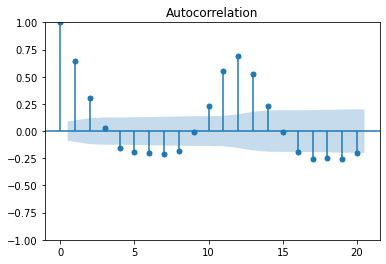

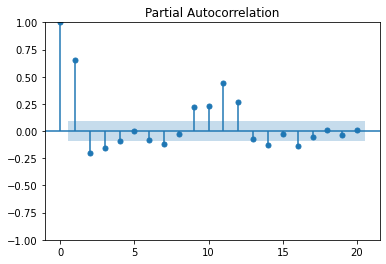

In [31]:
# from datetime import datetime
# df['dated'] = pd.to_datetime(df['date'])
# df = df.set_index('dated')
# df.drop(['date'], axis=1, inplace=True)
# fig, ax = plt.subplots(figsize=(12, 8))
sm.graphics.tsa.plot_acf(ts, lags=20)
sm.graphics.tsa.plot_pacf(ts, lags=20)
plt.show()

In [10]:
print(mk.seasonal_test(ts,period=12))

Seasonal_Mann_Kendall_Test(trend='increasing', h=True, p=0.0, z=14.083281462319537, Tau=0.44136178861788616, s=4343.0, var_s=95054.33333333334, slope=0.024074074074075337, intercept=298.2424845679012)


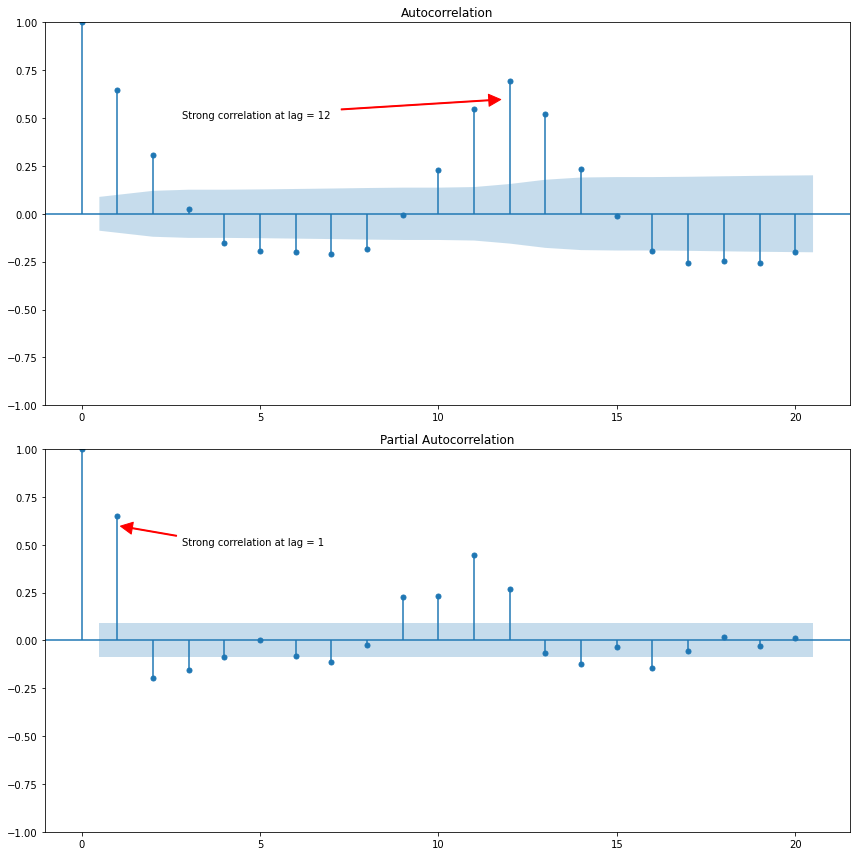

In [55]:
width=12
height=6
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(width, 2*height))
plot_acf(ts,lags=20, ax=ax[0])
plot_pacf(ts,lags=20, ax=ax[1], method='ols')

ax[1].annotate('Strong correlation at lag = 1', xy=(1, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))
ax[0].annotate('Strong correlation at lag = 12', xy=(12, 0.6),  xycoords='data',
            xytext=(0.17, 0.75), textcoords='axes fraction',
            arrowprops=dict(color='red', shrink=0.05, width=1))

plt.tight_layout()
plt.show()


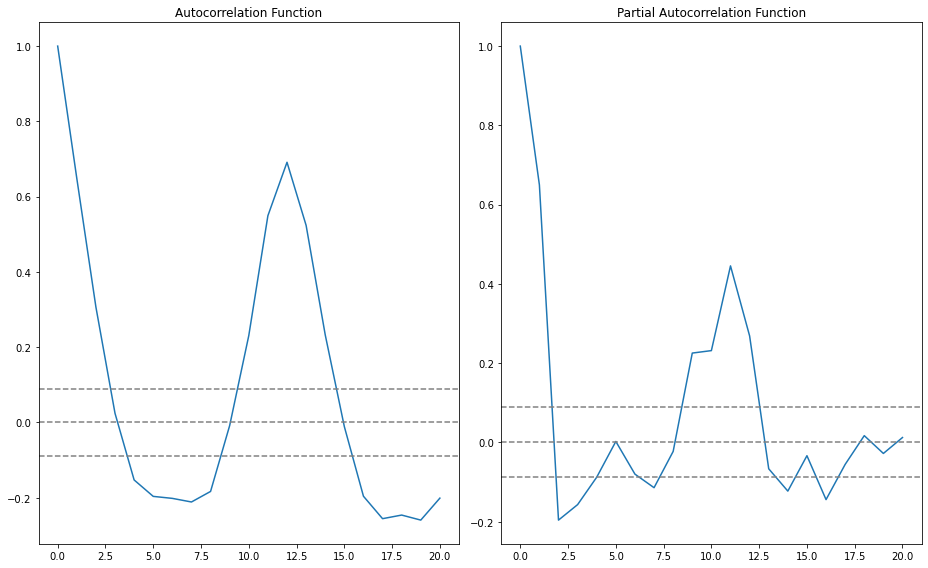

In [57]:
# ACF and PACF plots:
rcParams['figure.figsize'] = 13, 8
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(ts, nlags=20)
lag_pacf = pacf(ts, nlags=20, method='ols')
#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

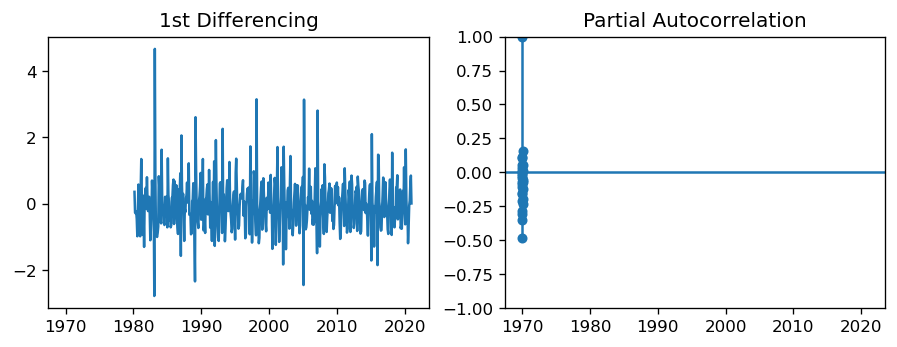

In [59]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(ts.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(ts.diff().dropna(), ax=axes[1])

plt.show()

In [77]:
from statsmodels.tsa.arima.model import ARIMA

# 1,1,2 ARIMA Model
model = ARIMA(ts, order=(1,0,12))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            Temperature   No. Observations:                  492
Model:                ARIMA(1, 0, 12)   Log Likelihood                -447.721
Date:                Wed, 20 Jul 2022   AIC                            925.442
Time:                        15:53:57   BIC                            988.419
Sample:                    01-31-1980   HQIC                           950.171
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        298.7657      0.097   3086.870      0.000     298.576     298.955
ar.L1          0.6355      0.094      6.777      0.000       0.452       0.819
ma.L1         -0.0272      0.084     -0.324      0.7

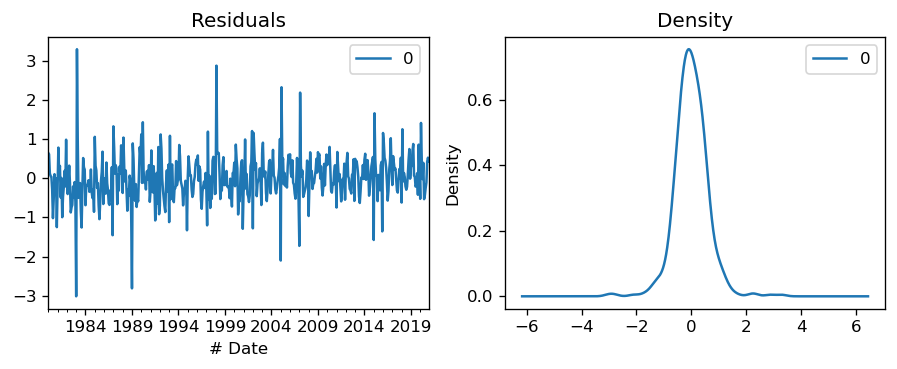

In [70]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [120]:
# Actual vs Fitted
predictions=model_fit.predict(start=0, end=491, exog=None, dynamic=False)

# model_fit.predict(start=1, end=24, exog=None, dynamic=False)

<AxesSubplot:xlabel='# Date'>

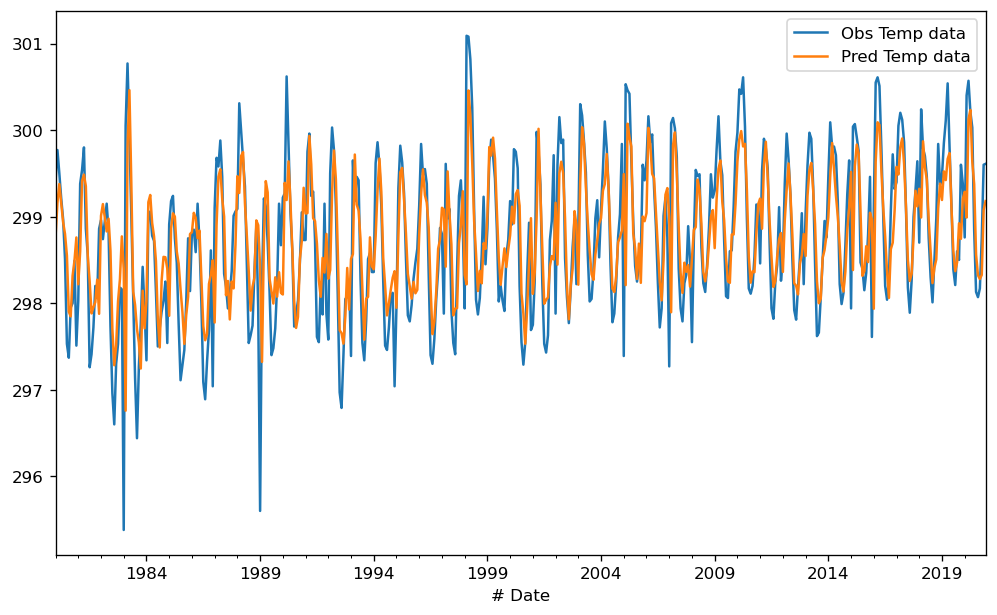

In [121]:
ts.plot(legend=True, label='Obs Temp data', figsize=(10,6))
predictions.plot(legend = True, label = 'Pred Temp data')


<AxesSubplot:xlabel='# Date'>

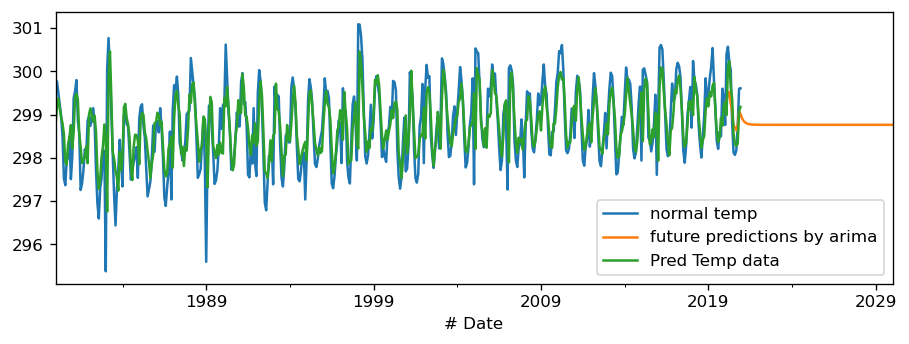

In [144]:
future_pred=model_fit.predict(start=480, end=600, exog=None, dynamic=True)
ts.plot(legend=True, label = 'normal temp' )
future_pred.plot(legend=True, label = 'future predictions by arima')
predictions.plot(legend = True, label = 'Pred Temp data')

In [106]:
model=sm.tsa.statespace.SARIMAX(ts,order=(1, 0, 1),seasonal_order=(1,1,3,12))
pred=model.fit()
print(pred.summary())


                                         SARIMAX Results                                          
Dep. Variable:                                Temperature   No. Observations:                  492
Model:             SARIMAX(1, 0, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -299.471
Date:                                    Wed, 20 Jul 2022   AIC                            612.942
Time:                                            16:13:19   BIC                            642.158
Sample:                                        01-31-1980   HQIC                           624.426
                                             - 12-31-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9656      0.021     45.055      0

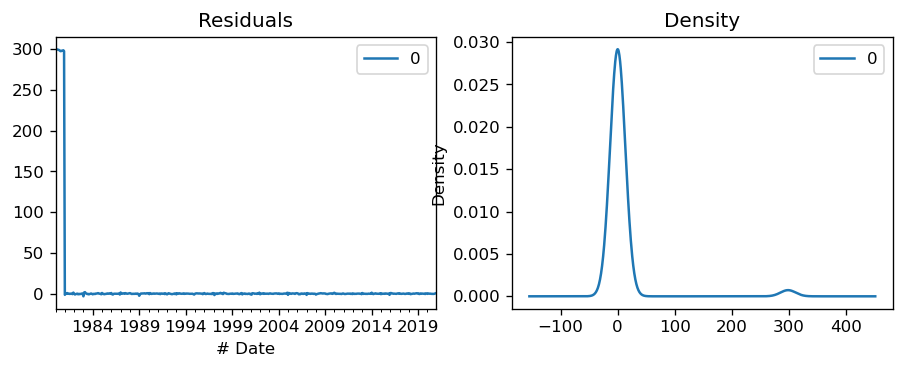

In [134]:
residuals = pd.DataFrame(pred.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [101]:
predictions1=pred.predict(start=20, end=491, exog=None, dynamic=False)

<AxesSubplot:xlabel='# Date'>

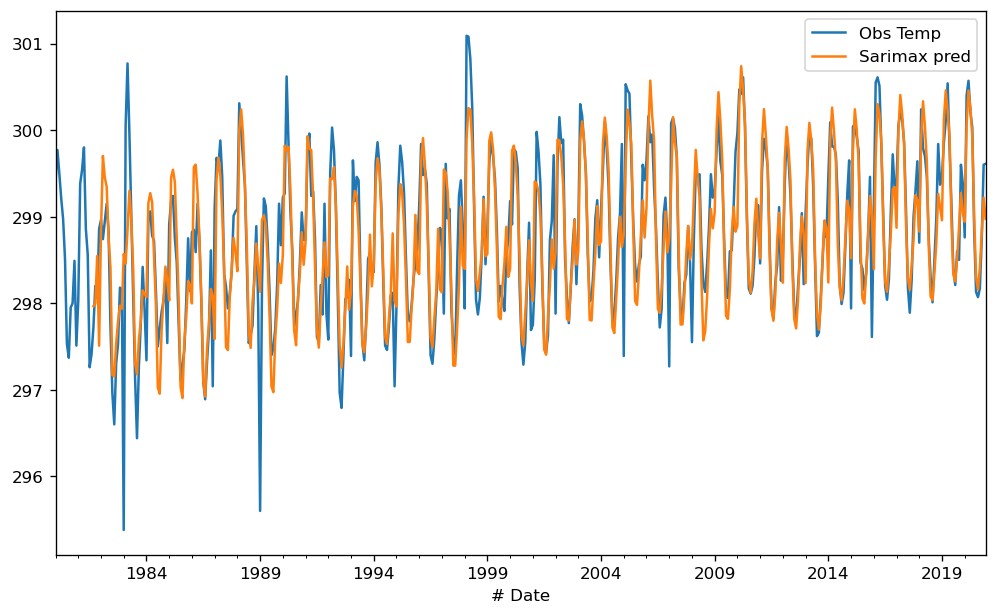

In [129]:
ts.plot(legend=True, label='Obs Temp', figsize=(10,6))
predictions1.plot(legend = True, label = 'Sarimax pred')


<AxesSubplot:xlabel='# Date'>

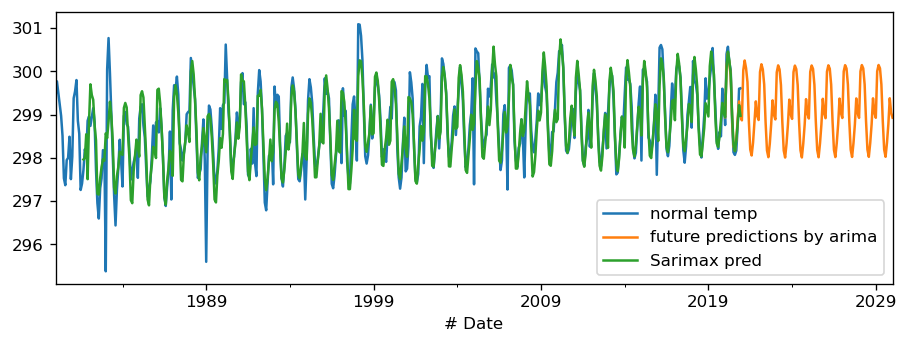

In [139]:
fut_pred=pred.predict(start=480, end=600, exog=None, dynamic=True)
ts.plot(legend=True, label = 'normal temp' )
fut_pred.plot(legend=True, label = 'future predictions by arima')
predictions1.plot(legend = True, label = 'Sarimax pred')

In [98]:
predictions1

# Date
1980-01-31      0.000000
1980-02-29      0.000035
1980-03-31      0.000065
1980-04-30      0.000091
1980-05-31      0.000114
                 ...    
2020-08-31    298.157291
2020-09-30    298.407304
2020-10-31    298.819386
2020-11-30    299.219805
2020-12-31    298.975139
Freq: M, Name: predicted_mean, Length: 492, dtype: float64

In [107]:
model=sm.tsa.statespace.SARIMAX(ts,order=(2, 0, 1),seasonal_order=(1,1,3,12))
pred1=model.fit()
print(pred1.summary())

                                         SARIMAX Results                                          
Dep. Variable:                                Temperature   No. Observations:                  492
Model:             SARIMAX(2, 0, 1)x(1, 1, [1, 2, 3], 12)   Log Likelihood                -297.803
Date:                                    Wed, 20 Jul 2022   AIC                            611.607
Time:                                            16:13:54   BIC                            644.997
Sample:                                        01-31-1980   HQIC                           624.732
                                             - 12-31-2020                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0949      0.048     22.668      0

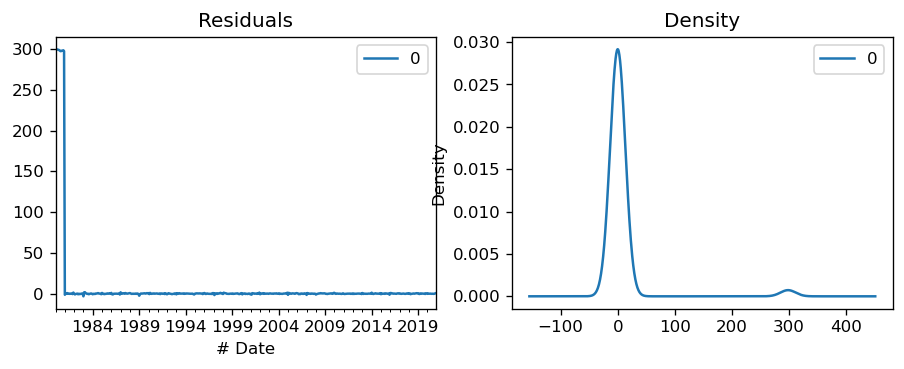

In [135]:
residuals = pd.DataFrame(pred1.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [116]:
predictions2=pred1.predict(start=15, end=491, exog=None, dynamic=False)

<AxesSubplot:xlabel='# Date'>

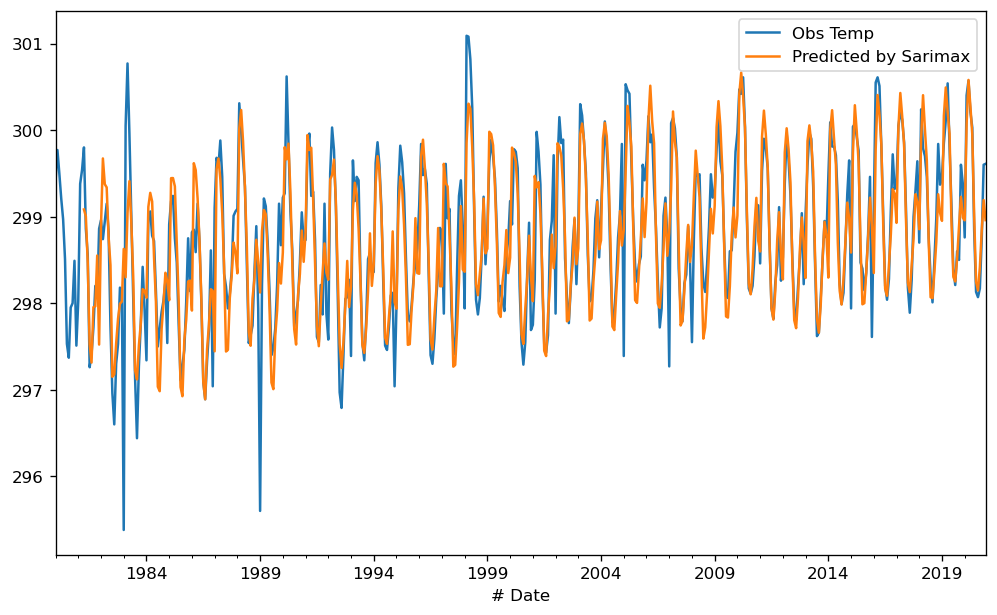

In [142]:
ts.plot(legend=True, label='Obs Temp', figsize=(10,6))
predictions2.plot(legend = True, label = 'Predicted by Sarimax')

<AxesSubplot:xlabel='# Date'>

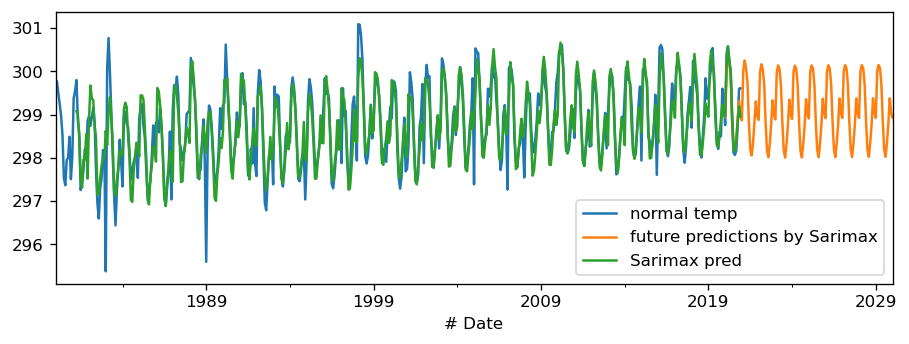

In [141]:
fut_pred1=pred1.predict(start=480, end=600, exog=None, dynamic=True)
ts.plot(legend=True, label = 'normal temp' )
fut_pred.plot(legend=True, label = 'future predictions by Sarimax')
predictions2.plot(legend = True, label = 'Sarimax pred')

In [147]:
train = ts[:393]
test = ts[393:]